# Opimisation thèse Manon

### Import des librairies

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt

from nptyping import NDArray, Float, Shape
from collections.abc import Callable
from mpl_toolkits.mplot3d import axes3d

#Custom type hints
Vector = npt.NDArray[np.float64] # Column vector (n,1)
VectorArray = npt.NDArray[np.float64] # Array (n,N)
ScalarArray = npt.NDArray[np.float64] # Array (1,n)
Matrix = npt.NDArray[np.float64] # Array (n,n)

### Custom type

## Custom plot 3D

### Code

In [4]:
def convert(function: Callable[[VectorArray],float], Xgrid: Matrix, Ygrid: Matrix, pointByPoints=False) -> Matrix:
    """Permet de convertir une fonction prenant un array de points en une fonction prenant une grille (pour l'affichage 3D)."""
    points = np.vstack([Xgrid.flatten(), Ygrid.flatten()])
    if pointByPoints:
        Zgrid = np.zeros(Xgrid.shape)
        for i in range(Xgrid.shape[0]):
            for j in range(Xgrid.shape[1]):
                x,y = Xgrid[i,j], Ygrid[i,j]
                Zgrid[i,j] = function(np.array([[x],[y]]))
    else:
        Zgrid = function(points).reshape(Xgrid.shape)
    return Zgrid

In [5]:
def comparaison3DPlot(function_to_plot: Callable[[VectorArray],ScalarArray], 
                      domain: list[Matrix], 
                      function_constrain: Callable[[VectorArray],ScalarArray]=None, 
                      points: VectorArray=None, pointByPoints=False):
    """
    Affichage comparatif (3D et projeté dans le plan) d'une fonction avec affichage de la contrainte et de points si besoin.
    
    La contrainte est respectée si la fonction est positive;
    Le domain (domain) est sous la forme d'une meshgrid;
    """
    # Création de l'espace figure
    fig = plt.figure(figsize=plt.figaspect(0.45),layout='constrained')
    fig.suptitle("Etat de l'optimisation")
    
    # Plot 3D et 2D
    ax3D = fig.add_subplot(1, 2, 2, projection='3d')
    ax2D = fig.add_subplot(1, 2, 1)
    X, Y = domain
    
    # coût
    Zcout = convert(function_to_plot, X, Y,pointByPoints=pointByPoints)
    surfCout = ax3D.plot_surface(X, Y, Zcout, rstride=1, cstride=1, linewidth=0, antialiased=True, color="purple", alpha=0.6, label="coût")
    flatCout = ax2D.pcolormesh(X, Y, Zcout, cmap="plasma")
    flatContourCout = ax2D.contour(X,Y,Zcout,cmap="Greys")
    
    # contrainte
    if not(function_constrain is None):
        Zcont = convert(function_constrain, X, Y,pointByPoints=pointByPoints)
        flatCont = ax2D.contour(X,Y,Zcont,levels=[0.])
        contour3DCont = ax3D.contourf(X,Y,Zcont,levels=[np.min(Zcont),0.,np.max(Zcont)],offset=np.min(Zcout),alpha=0.7)
        
        ax2D.clabel(flatCont, fmt="contrainte")
        fig.colorbar(contour3DCont, ax=ax3D, label="contrainte")
        
    # points
    if not(points is None):
        points_2D_2D = ax2D.plot(points[0,:], points[1,:], color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], np.zeros(points[0,:].shape)+np.min(Zcout), color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], function_to_plot(points), color="orange", marker="x", label="points")
        ax2D.legend()
        
    # Cosmétique
    ax3D.grid(True)
    ax3D.set_xlabel('x1')
    ax3D.set_ylabel('x2')
    ax3D.set_zlabel('z')
    ax3D.set_zlim([np.min(Zcout),np.max(Zcout)])
    ax3D.legend()
    ax2D.clabel(flatContourCout, fmt="niveaux coût")
    ax2D.grid(True)
    ax2D.set_xlabel('x1')
    ax2D.set_ylabel('x2')
    fig.colorbar(flatCout, ax=ax2D, label="coût")
    
    plt.show()

### Exemple de plot

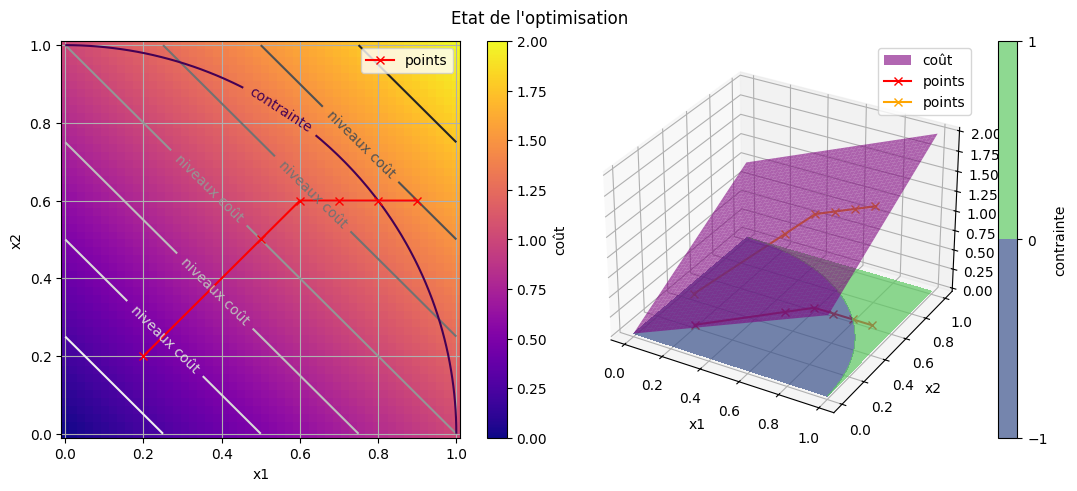

In [6]:
f_test = lambda points: points[0,:]+points[1,:]
h_test = lambda points: points[0,:]**2+points[1,:]**2-1

Xdomain = np.linspace(0,1)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f_test,[X,Y],h_test, points)

## Présentation du problème

#### Définition mathématique du problème

On souhaite résoudre le problème suivant :
$$
    \min_{x\in K} f(x), \quad \text{with } K=\{x\in(\mathbb{R}_+^*)^n \vert h(x)\leq 0\}.
$$
Avec :
$$
    f(x)=\sum_{i=1}^n x_i, \quad h(x)=\text{Module de stabilité de la matrice }A(x)=\max_{\lambda\in\text{Spec}(A(x))}\text{Re}(\lambda).
$$

### Définitions basiques

#### Matrice A(x)

In [7]:
# Matrice D (points du graph)
D12=1.4
D21=0.8
D13 = 0.8
D31 = 0.2
D32 = 0.6
D23 = 0.5

D = np.array([[-D21-D31,D12,D13],
              [D21,-D12-D32,D23],
              [D31,D32,-D13-D23]])
# D42 = 0; D52 = 0; D24 = 0; D25=0;D43=0;D53=0;D34=0;D35=0

# Constantes et fonctions
geneGFonc = lambda a,K: lambda x: a-x/K
g1= geneGFonc(0.7, 2)
g2= geneGFonc(0.5, 3)
g3= geneGFonc(0.2, 4)

def A(points: VectorArray) -> list[Matrix]:
    """Fonction A optimisée pour le calcul."""
    return [np.diag([g1(0)-p[0],g2(0)-p[1],g3(0)]) +D for p in points.T]

#### Module de stabilité (contrainte)

In [8]:
def h_old(x: Vector) -> float:
    eigv, eigp = np.linalg.eig(A(x))
    real = eigv.real
    return max(real)

def h(points: VectorArray) -> ScalarArray:
    """Fonction h optimisée pour le calcul. En sachant que l'on se met dans le cas """
    listeA = A(points)
    if not(type(listeA) is list):
        listeA = [listeA]
        print(listeA)
    return np.array([np.max(np.linalg.eig(matA)[0].real) for matA in listeA])

#### Coût et affichage

In [9]:
def f(points: VectorArray) -> ScalarArray:
    """Fonction de coût f optimisée."""
    return points[0,:]+points[1,:]

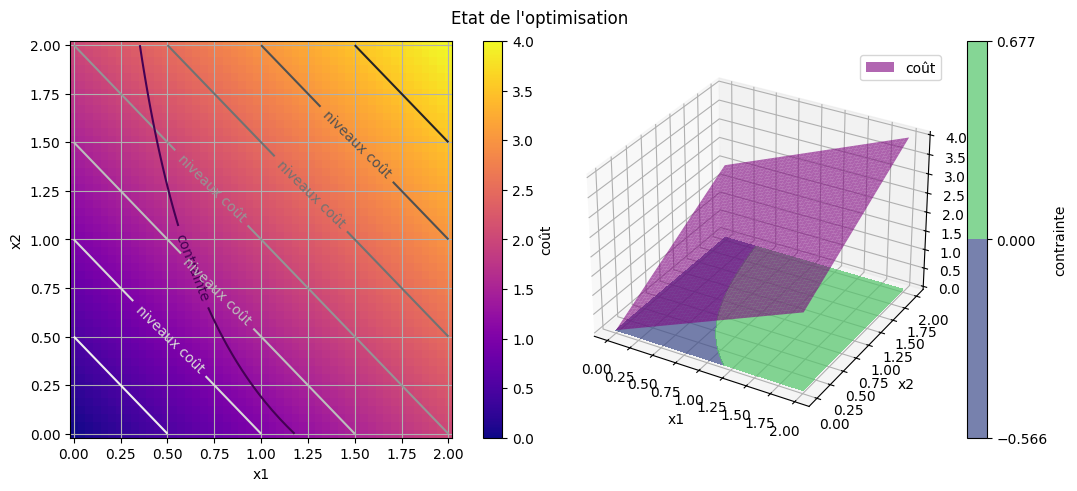

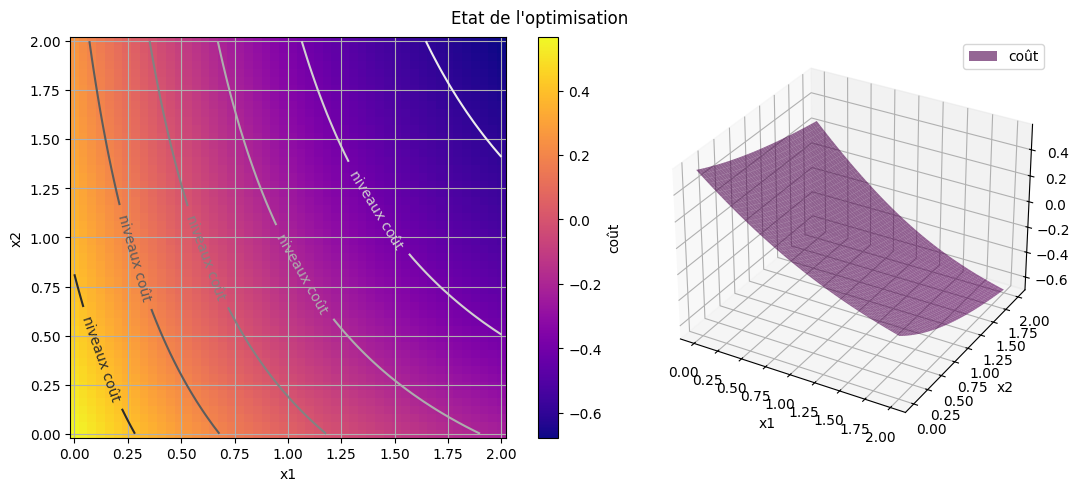

In [10]:
Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f,[X,Y],lambda pts: -h(pts))
comparaison3DPlot(h,[X,Y])

### Pré-calculs pour l'optimisation

In [11]:
def Q(X: Vector) -> Matrix:
    return h(X)*np.eye(np.shape(X)[1])-A(X)[0]

def pseudo_inv_Q(X: Vector):
    return np.linalg.pinv(Q(X))

def gradh(X: Vector) -> Vector:
    nC = np.shape(X)[1]
    return np.diag(np.eye(nC) - Q(X)@pseudo_inv_Q(X))[:nC]

def hessh(X: Vector) -> Matrix:
    nC = np.shape(X)[1]
    
    Qinv = pseudo_inv_Q(X)
    mat_idQ = (np.eye(nC) - Q(X)@Qinv)[:nC,:nC]
    Qinv = Qinv[:nC,:nC]
    return (mat_idQ*(Qinv.T) + (mat_idQ.T)*Qinv)

def gradientOptim(X: Vector, t: float) -> Vector:
    nC = np.shape(X)[1]
    
    gradf = np.ones((1,nC))
    gradlogh = 1/h(X)*gradh(X)
    gradlog = 1/X
    
    return t*gradf + gradlogh - gradlog 

def hessOptim(X: Vector, t: float) -> Matrix:
    nC = np.shape(X)[1]
    gradh_X = gradh(X)
    
    hessf = np.zeros((nC,nC))
    hesslogh = 1/h(X)*(hessh(X)-gradh_X@(gradh_X.T)/h(X))
    hesslog = np.diag(1/(X.flatten()**2))
    
    return t*hessf + hesslogh + hesslog 

## Optimisation par points intérieur

### Méthode

On applique la méthode de Newton à la fonction suivante (à $t$ fixé):
$$
    f_{\phi,t}(x)=tf(t)-\phi(x),\quad \phi(x)=\ln(-h(x))+\ln(x_i).
$$
A chaque étape on multiplie $t$ par $\mu>1$ jusqu'à ce que $t>1/\varepsilon$.

### Newton

In [36]:
def optimalStep(function, constrain, deltaX, X):
    """Trouve le pas optimal à appliquer"""
    valf0 = function(X)
    valf = function(X-deltaX)
    valh = constrain(X-deltaX)
    niter = 0
    
    while (valf>valf0 or valh>0) and niter<20:
        deltaX = deltaX/2
        valf = function(X-deltaX)
        valh = constrain(X-deltaX)
        niter += 1
        
    if niter==20:
        print("minimal step reached : check your gradient.")
    return X-deltaX
    

def newton(gradient: Callable[[Vector], Vector], 
           hess: Callable[[Vector], Matrix],
           x0: Vector, tolerance: float, maxIter: int,
           function, constrain=lambda x: -1) -> (VectorArray, float, int):
    """Methode de Newton prenant un gradient et une hessienne."""
    # Initialisation
    points = x0.copy()
    x = x0
    nbxIter = 0
    previousGradient = gradient(x)
    error = np.linalg.norm(previousGradient)
    
    # Boucle
    while (error >= tolerance) and (nbxIter <= maxIter):
        deltaX = np.linalg.solve(hess(x), previousGradient)
        x = optimalStep(function, constrain, deltaX, x)
        
        points = np.concatenate((points, x.copy()), axis=1)
        previousGradient = gradient(x)
        error = np.linalg.norm(previousGradient)
        nbxIter += 1
    
    return points, error, nbxIter

#### Test rapide Newton

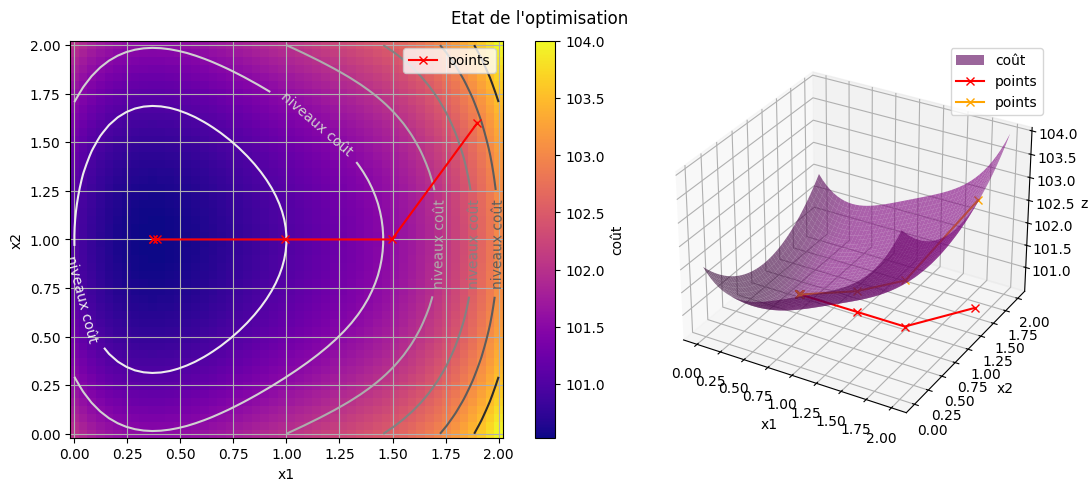

In [13]:
f_test2 = lambda points: (points[0,:]-1)**4+ (points[1,:]-1)**2 + points[0,:] +100
gradient_test2 = lambda x: np.array([[4*(x[0,0]-1)**3+1],[2*(x[1,0]-1)]])
hess_test2 = lambda x: np.array([[12*(x[0,0]-1)**2,0],[0,2]])

Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points, error, nbxIter = newton(gradient_test2, hess_test2, np.array([[1.9],[1.6]]), 1e-5, 50, f_test2)
        
comparaison3DPlot(f_test2,[X,Y],points=points)

### Points intérieurs

In [14]:
def modified_f(t,x,function,constrain,plot=False):
    if plot:
        valH = np.where(-h(x) < 2e-2, 2e-2, -constrain(x))
        valX = np.where(x < 2e-2, 2e-2, x)
    else:
        valH = -constrain(x)
        valX = x
    return t*function(x)-np.log(valH)-np.sum(np.log(valX))

In [34]:
def interiorPoint(gradient: Callable[[Vector, float], Vector], 
                  hess: Callable[[Vector, float], Matrix],
                  x0: Vector, tolerance: float, maxIter: int,
                  t0: float, eps: float, mu: float, function, constrain) -> (VectorArray, float, int):
    """Methodes des points intérieurs."""
    # Initialisation
    points = x0.copy()
    x = x0
    nbxIter = 0
    t = t0
    
    Xdomain = np.linspace(0,3,70)
    X,Y = np.meshgrid(Xdomain,Xdomain)
    # Boucle
    while 1/t>eps and nbxIter <= maxIter:
        modified_gradient = lambda x: gradient(x,t)
        modified_hess = lambda x: hess(x,t)
        updated_f = lambda x: modified_f(t,x,function,constrain)
        
        pointsNewton, errorNewton, nbxIterNewton = newton(modified_gradient, modified_hess, x, tolerance, maxIter,function,constrain)
        error = errorNewton
        points = np.concatenate((points, pointsNewton.copy()), axis=1)
        
        comparaison3DPlot(lambda x: modified_f(t,x,function,constrain,True), [X,Y],h, pointsNewton)
        
        t = mu*t
        x[:,0] = pointsNewton[:,-1]
        nbxIter += 1
        
    return points, error, nbxIter


#### Test rapide intérieurs

/tmp/ipykernel_660/4050445659.py:7: RuntimeWarning: divide by zero encountered in divide
  gradh = 2/h_test2(X)*np.array([[x],[y]])
/tmp/ipykernel_660/4050445659.py:14: RuntimeWarning: divide by zero encountered in divide
  hessh = -4/(h_test2(X)**2)*np.array([[x**2, x*y],[x*y, y**2]]) + 2/h_test2(X)*np.eye(2)
/tmp/ipykernel_660/4050445659.py:14: RuntimeWarning: invalid value encountered in multiply
  hessh = -4/(h_test2(X)**2)*np.array([[x**2, x*y],[x*y, y**2]]) + 2/h_test2(X)*np.eye(2)


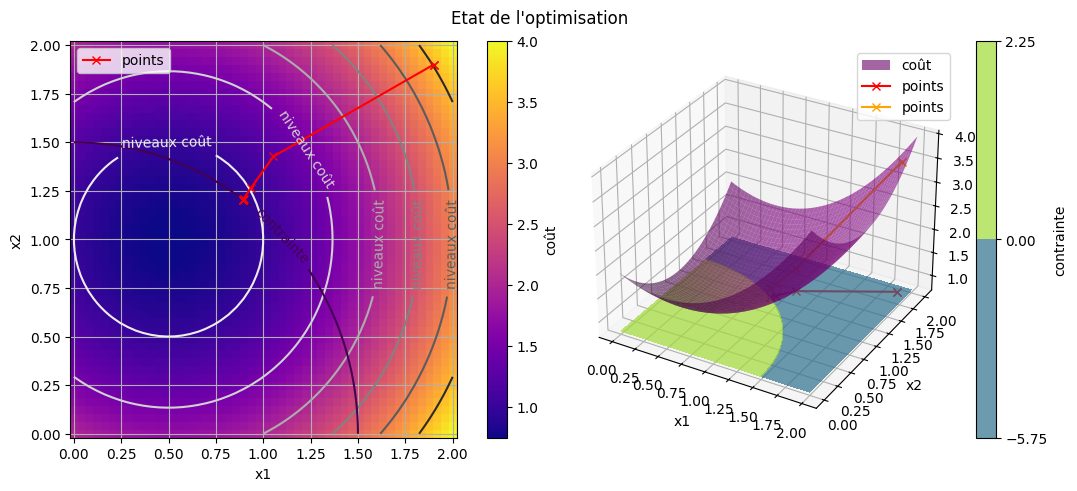

In [19]:
f_test2 = lambda points: (points[0,:]-1)**2+ (points[1,:]-1)**2 + points[0,:]
h_test2 = lambda points: -(points[0,:]**2+points[1,:]**2-1.5**2)

def gradient(X,t):
    x,y = X[0,0], X[1,0]
    gradf = 2*np.array([[x-0.5],[y-1]])
    gradh = 2/h_test2(X)*np.array([[x],[y]])
    gradlog = np.array([[1/x],[1/y]])
    return t*gradf-gradh-gradlog
    
def hess(X,t):
    x,y = X[0,0], X[1,0]
    hessf = 2*np.eye(2)
    hessh = -4/(h_test2(X)**2)*np.array([[x**2, x*y],[x*y, y**2]]) + 2/h_test2(X)*np.eye(2)
    hesslog = -np.array([[1/(x**2), 0],[0, 1/(y**2)]])
    return t*hessf-hessh-hesslog

Xdomain = np.linspace(0,2)
X,Y = np.meshgrid(Xdomain,Xdomain)
points, error, nbxIter = interiorPoint(gradient, hess, np.array([[1.9],[1.9]]), 1e-8, 20, 1, 1e-6, 1.5,f_test2,h_test2)
        
comparaison3DPlot(f_test2,[X,Y],h_test2, points)

## Applications

minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.
minimal step reached : check your gradient.


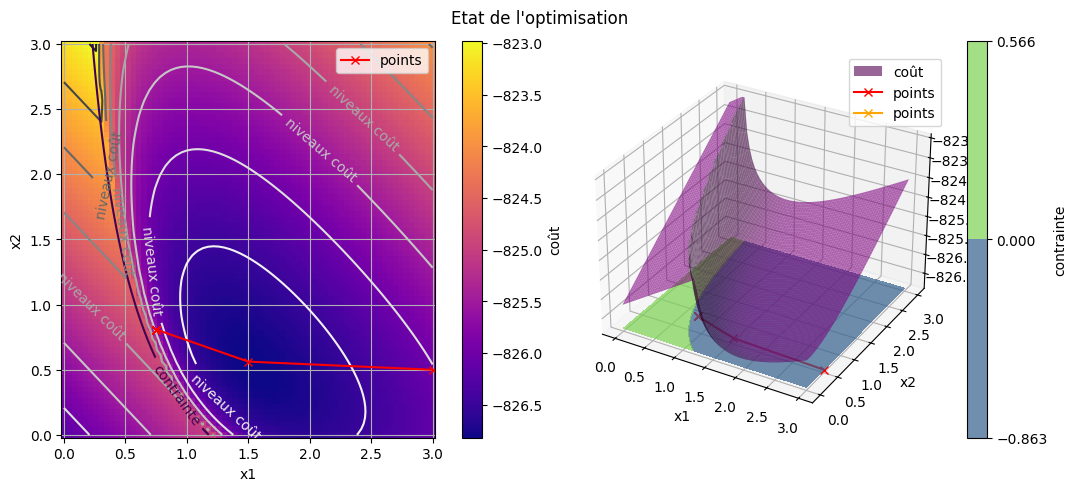

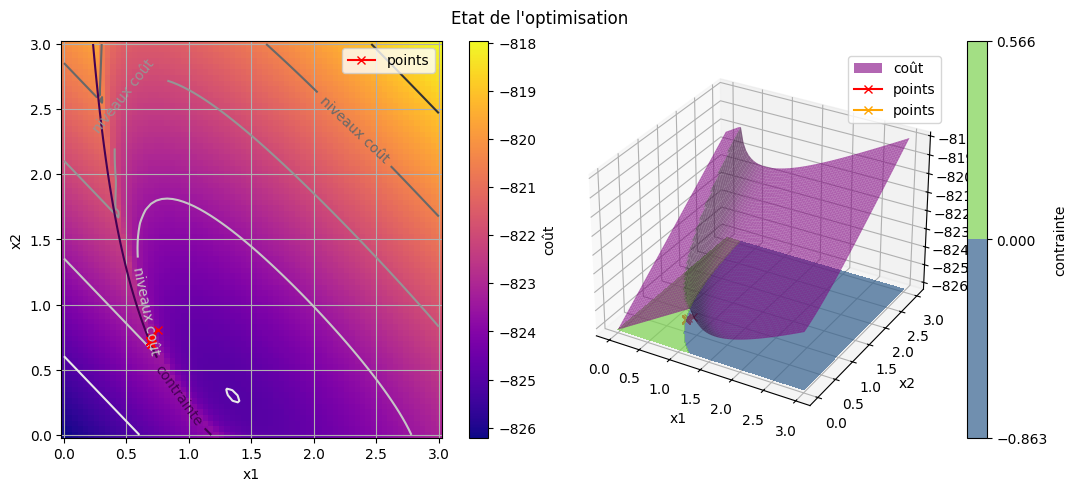

2


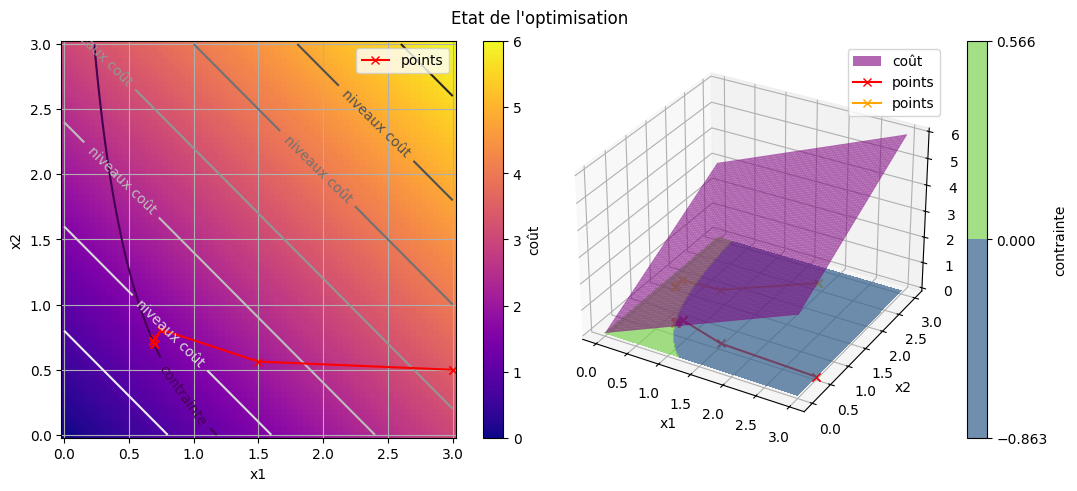

In [37]:
Xdomain = np.linspace(0,3,70)
X,Y = np.meshgrid(Xdomain,Xdomain)
points, error, nbxIter = interiorPoint(gradientOptim, hessOptim, np.array([[3],[0.5]]), 1e-6, 10, 1, 0.4, 2,f,h)
print(nbxIter)
        
comparaison3DPlot(f,[X,Y],h, points)